# <p style="text-align: center;, font-style: strong;">Anonymization with Tensorflow Scala</p>


*Only for RVB image, small changes are necessary if you need to use it for grascales image*

## Dependencies

In [4]:
interp.load.ivy("com.github.haifengl" % "smile-scala_2.12" % "1.5.2")

In [5]:
interp.load.ivy(
  coursier.Dependency(
    module = coursier.Module("org.platanios", "tensorflow_2.12"),
    version = "0.4.1",
    // replace with linux-gpu-x86_64 on linux with nvidia gpu or with darwin-cpu-x86_64 on macOS 
    attributes = coursier.Attributes("", "darwin-cpu-x86_64")
  )
)
interp.load.ivy("org.platanios" %% "tensorflow-data" % "0.4.1")

interp.load.ivy(
  coursier.Dependency(
    module = coursier.Module(coursier.Organization("org.platanios"), coursier.ModuleName("tensorflow_2.12")),
    version = "0.4.1",
    // replace with linux-gpu-x86_64 on linux with nvidia gpu or with darwin-cpu-x86_64 on macOS 
    attributes = coursier.Attributes(coursier.Type(""), coursier.Classifier("darwin-cpu-x86_64"))
  )
)
interp.load.ivy("org.platanios" %% "tensorflow-data" % "0.4.1")



In [6]:
import org.tensorflow.framework.GraphDef
import org.platanios.tensorflow.api._
import org.platanios.tensorflow.api.ops.{Files, Image => TImage}
import org.platanios.tensorflow.api.core.types.UByte
import org.platanios.tensorflow.api.core.client.FeedMap
import java.io.{BufferedInputStream, File, FileInputStream}
import scala.math.sqrt
import scala.math.abs
import smile.stat.distribution.GaussianDistribution
import org.platanios.tensorflow.api.ops.NN._

import org.tensorflow.framework.GraphDef

import org.platanios.tensorflow.api._

import org.platanios.tensorflow.api.ops.{Files, Image => TImage}

import org.platanios.tensorflow.api.core.types.UByte

import org.platanios.tensorflow.api.core.client.FeedMap

import java.io.{BufferedInputStream, File, FileInputStream}

import scala.math.sqrt

import scala.math.abs

import smile.stat.distribution.GaussianDistribution

import org.platanios.tensorflow.api.ops.NN._

## Initialization
*Modify path to directories in function of your configuration*

In [7]:
val basedir = "data/models"
val modelname = "anonymizer"
val modelfilename = "weights_face_v1.0.0.pb"
val modelGraphPath = sys.env.getOrElse("HOME", "/tmp") + s"/${basedir}/${modelname}/${modelfilename}"

val imageFilePath = sys.env("HOME") + "/Downloads/baywatch.png"

basedir: String = "data/models"
modelname: String = "anonymizer"
modelfilename: String = "weights_face_v1.0.0.pb"
modelGraphPath: String = "/Users/xavier/data/models/anonymizer/weights_face_v1.0.0.pb"
imageFilePath: String = "/Users/xavier/Downloads/baywatch.png"

val basedir = "data/models"
val modelname = "anonymizer"
val modelfilename = "weights_face_v1.0.0.pb"
val imageFilePath = sys.env("HOME") + "/Desktop/audiScala/xavier/coco01.png"
val modelGraphPath = sys.env.getOrElse("HOME", "/tmp") + s"/Desktop/audiScala/xavier/${modelfilename}"

In [8]:
lazy val graphDef = GraphDef.parseFrom(
    new BufferedInputStream(new FileInputStream(new File(modelGraphPath))))
lazy val graph = Graph.fromGraphDef(graphDef)

graphDef: GraphDef = <lazy>
graph: Graph = <lazy>

In [9]:
val session = Session(graph)
val sessionSimple = Session()

session: Session = org.platanios.tensorflow.api.core.client.Session@59e0f235
sessionSimple: Session = org.platanios.tensorflow.api.core.client.Session@4155cce6

## Prepare recuperation of graph results

In [10]:
val imagePlaceholder = graph.getOutputByName("image_tensor:0").toUByte
val detectionBoxes = graph.getOutputByName("detection_boxes:0").toFloat
val detectionScores = graph.getOutputByName("detection_scores:0").toFloat
val detectionClasses = graph.getOutputByName("detection_classes:0").toFloat
val numDetections = graph.getOutputByName("num_detections:0").toFloat


imagePlaceholder: Output[UByte] = Output(image_tensor, 0)
detectionBoxes: Output[Float] = Output(detection_boxes, 0)
detectionScores: Output[Float] = Output(detection_scores, 0)
detectionClasses: Output[Float] = Output(detection_classes, 0)
numDetections: Output[Float] = Output(num_detections, 0)

## Open and transform image

In [11]:
val (imgTensor, fileNamePlaceholder) = tf.createWith(graph = graph) {
    val fileNamePlaceholder = tf.placeholder[String]()
    val fileTensor = Files.readFile(fileNamePlaceholder)
    val imgTensor = TImage.decodePng(fileTensor, 3)
    (imgTensor, fileNamePlaceholder)
  }

imgTensor: Output[UByte] = Output(DecodePng, 0)
fileNamePlaceholder: Output[String] = Output(Placeholder, 0)

In [12]:
val file = new File(imageFilePath)
val fileNameTensor = Tensor.fill(Shape())(file.getAbsolutePath())
val feedImg = FeedMap(Map(fileNamePlaceholder -> fileNameTensor))

file: File = /Users/xavier/Downloads/baywatch.png
fileNameTensor: Tensor[String] = Tensor[String, []]
feedImg: FeedMap = org.platanios.tensorflow.api.core.client.FeedMap@77325a9c

In [13]:
val imageOuts: Tensor[UByte] = session.run(fetches = imgTensor, feeds = feedImg)

imageOuts: Tensor[UByte] = Tensor[UByte, [759, 1024, 3]]

In [14]:
val feeds = FeedMap(Map(imagePlaceholder -> imageOuts.slice(NewAxis, ---)))

feeds: FeedMap = org.platanios.tensorflow.api.core.client.FeedMap@213d33b6

## Detection of face 
*boxes* = Positions of face detected

*score* = Confidence for each detection

*classes* = Face or plate

*num* = Number of detection

In [15]:
val Seq(boxes, scores, classes, num) =
      session.run(
        fetches =
          Seq(detectionBoxes, detectionScores, detectionClasses, numDetections),
        feeds = feeds)

boxes: Tensor[Float] = Tensor[Float, [1, 100, 4]]
scores: Tensor[Float] = Tensor[Float, [1, 100]]
classes: Tensor[Float] = Tensor[Float, [1, 100]]
num: Tensor[Float] = Tensor[Float, [1]]

In [16]:
val width = imageOuts.shape(1)
val height = imageOuts.shape(0)
val thereshold = 0.7

width: Int = 1024
height: Int = 759
thereshold: Double = 0.7

## Filter detections to keep only one above our thereshold

In [17]:
val tabBoxes = for {
    i <- 0 until num(0).scalar.asInstanceOf[Float].toInt
    labelId = classes(0, i).toFloat.scalar.toInt
    box = boxes(0, i).toFloat.entriesIterator.toSeq
    y1 = (box(0) * height).toInt
    x1 = (box(1) * width).toInt
    y2 = (box(2) * height).toInt
    x2 = (box(3) * width).toInt
    labelBox = (y1, x1, y2, x2)
    score = scores(0, i).toFloat.scalar
  } yield (labelId, score, labelBox)

val tabBoxesFiltered = tabBoxes.filter {case (_,y,_) => y > thereshold}
()

tabBoxes: collection.immutable.IndexedSeq[(Int, Float, (Int, Int, Int, Int))] = Vector(
  (1, 0.9979475F, (110, 676, 239, 770)),
  (1, 0.9971578F, (40, 267, 165, 358)),
  (1, 0.017626688F, (146, 191, 433, 428)),
  (1, 0.007726916F, (93, 174, 502, 527)),
  (1, 0.0041234437F, (89, 266, 120, 279)),
  (1, 0.0034511643F, (36, 287, 187, 378)),
  (1, 0.0024264304F, (192, 171, 353, 253)),
  (1, 0.00193953F, (161, 176, 411, 356)),
  (1, 0.0015718903F, (53, 268, 141, 305)),
  (1, 0.0014381484F, (225, 167, 357, 236)),
  (1, 0.0011615454F, (52, 268, 160, 329)),
  (1, 0.0011185665F, (126, 677, 234, 738)),
  (1, 0.0010879941F, (164, 156, 378, 273)),
  (1, 0.0010068403F, (543, 836, 614, 879)),
  (1, 9.1689103E-4F, (122, 672, 215, 718)),
  (1, 8.236501E-4F, (161, 671, 194, 687)),
  (1, 7.8261615E-4F, (95, 652, 255, 781)),
  (1, 6.5136445E-4F, (83, 268, 124, 286)),
  (1, 6.5032666E-4F, (280, 182, 354, 224)),
  (1, 5.613027E-4F, (691, 625, 756, 697)),
  (1, 5.604698E-4F, (97, 308, 167, 357)),
  (1, 4.79

## Create a mask to delimitate areas where the blurring need to be apply in the image


In [18]:
// 0 is corresponding to an area where no blur is necessary and 1 is the opposite
val maskBlur = Array.fill(height, width)(0)

maskBlur: Array[Array[Int]] = Array(
  Array(
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
...

In [19]:
// Thanks to the box detection, we fill our mask with 1 where we need to apply blurring
tabBoxesFiltered.map {case (x,y,z) => z}
                .foreach {case (x1,y1,x2,y2) => (x1 until x2)
                    .foreach(xi => (y1 until y2)
                        .foreach(yi => maskBlur(xi)(yi) = 1))
}
val maskBlurFlatten = maskBlur.flatten

maskBlurFlatten: Array[Int] = Array(
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
...

In [20]:
val tensorMaskFlatten = Tensor(maskBlurFlatten)
val tensorMaskReshape = tf.reshape(tensorMaskFlatten, Shape(height, width))

tensorMaskFlatten: Tensor[Int] = Tensor[Int, [1, 777216]]
tensorMaskReshape: Output[Int] = Output(Reshape, 0)

## Params for blurring and smoothing

In [21]:
val channels = 3 // RVB = 3
val smooth_boxes = true // Smooth area around blurring
val kernel_size = 21 // Kernel for blurring
val sigma = 2 // Standard deviation for blurring
val box_kernel_size = 9 // Size for smoothing, need to be > 1

channels: Int = 3
smooth_boxes: Boolean = true
kernel_size: Int = 21
sigma: Int = 2
box_kernel_size: Int = 9

## Generate a 2D gaussian filter...

In [22]:
val gaussian = new GaussianDistribution(0.0, sigma)

gaussian: GaussianDistribution = Gaussian Distribution(0.0000, 2.0000)

In [23]:
val interval = (2 * sigma + 1.0) / kernel_size

interval: Double = 0.23809523809523808

In [24]:
val g1dcdf = (-sigma - interval/2.0 to sigma + interval/2.0 by (2.0*sigma + interval)/kernel_size)
    .map(gaussian.cdf(_))

g1dcdf: collection.immutable.IndexedSeq[Double] = Vector(
  0.14468064587463358,
  0.16887591803796806,
  0.19552637728614436,
  0.2245840311830401,
  0.25594562025054657,
  0.28945120776044414,
  0.32488503633190235,
  0.36197877318156596,
  0.4004171250960385,
  0.4398456559849009,
  0.47988049602876326,
  0.520119503971237,
  0.5601543440150991,
  0.5995828749039616,
  0.6380212268184341,
  0.6751149636680976,
  0.7105487922395559,
  0.7440543797494534,
  0.77541596881696,
  0.8044736227138557,
  0.831124081962032,
  0.8553193541253665
)

In [25]:
val k1d = g1dcdf.sliding(2).map { case Seq(x, y) => y - x }.toArray

k1d: Array[Double] = Array(
  0.024195272163334475,
  0.0266504592481763,
  0.02905765389689574,
  0.03136158906750647,
  0.03350558750989757,
  0.035433828571458215,
  0.037093736849663606,
  0.038438351914472535,
  0.03942853088886239,
  0.040034840043862374,
  0.040239007942473703,
  0.04003484004386215,
  0.039428530888862445,
  0.038438351914472535,
  0.03709373684966355,
  0.03543382857145827,
  0.033505587509897516,
  0.03136158906750652,
  0.02905765389689574,
  0.026650459248176328,
  0.024195272163334502
)

In [26]:
val k1dSqrt = for {
    x <- k1d
    y <- k1d
} yield sqrt(x*y)

k1dSqrt: Array[Double] = Array(
  0.024195272163334475,
  0.025393210013455954,
  0.026515237967315492,
  0.027546364242182198,
  0.028472386777268814,
  0.029280217316054343,
  0.029958188507196493,
  0.03049633397772086,
  0.030886631992764535,
  0.031123204379960807,
  0.03120246382500473,
  0.03112320437996072,
  0.030886631992764556,
  0.03049633397772086,
  0.029958188507196472,
  0.029280217316054367,
  0.02847238677726879,
  0.027546364242182222,
  0.026515237967315492,
  0.02539321001345597,
  0.02419527216333449,
  0.025393210013455954,
  0.0266504592481763,
  0.027828040193783522,
  0.028910218805841516,
  0.02988208986196799,
  0.030729917089873708,
  0.03144145547322095,
  0.03200624519158268,
  0.03241586734408147,
  0.032664152722766446,
  0.032747336400964555,
  0.03266415272276636,
  0.03241586734408149,
  0.03200624519158268,
  0.03144145547322092,
  0.030729917089873732,
  0.029882089861967963,
...

In [27]:
val sumK1d = k1dSqrt.sum
val kernel = k1dSqrt.map(x => x/sumK1d)

sumK1d: Double = 14.826243684534887
kernel: Array[Double] = Array(
  0.0016319219269660548,
  0.0017127203999717992,
  0.0017883989047727093,
  0.0018579462760965912,
  0.0019204046138111225,
  0.001974891141617769,
  0.002020618920384102,
  0.0020569157385111167,
  0.002083240546287667,
  0.0020991968729358688,
  0.002104542761397597,
  0.0020991968729358627,
  0.002083240546287669,
  0.0020569157385111167,
  0.0020206189203841006,
  0.0019748911416177708,
  0.0019204046138111208,
  0.001857946276096593,
  0.0017883989047727093,
  0.0017127203999718,
  0.0016319219269660557,
  0.0017127203999717992,
  0.0017975193053096205,
  0.0018769447464842821,
  0.001949935494180329,
  0.0020154862214451334,
  0.0020726704446337807,
  0.0021206622622840896,
  0.0021587561807693808,
  0.0021863843623381256,
  0.0022031307064538613,
  0.002208741276465258,
  0.0022031307064538557,
  0.002186384362338127,
  0.0021587561807693808,
  0.002120662262284088,
  0.0020726704446337825,
  0.00201548622144513

In [28]:
val kernelBlurring = tf.reshape(kernel, Shape(kernel_size, kernel_size, 1, 1)).toFloat

kernelBlurring: Output[Float] = Output(Reshape_1_0/CastToFloat/Cast, 0)

## Generate smoothing filter

In [29]:
val filter_size = List(box_kernel_size, box_kernel_size)
val factor: List[Int] = filter_size.map(size => ((size + 1) / 2).toInt)
val centerX = if (filter_size(0) % 2 == 1) factor(0) - 1 else factor(0) - 0.5
val centerY = if (filter_size(1) % 2 == 1) factor(1) - 1 else factor(1) - 0.5

val vectorX = (0 until filter_size(0)).toList
val vectorY = (0 until filter_size(1)).toList
val kernelTemp = Array.ofDim[Float](filter_size(0), filter_size(1))

(0 until filter_size(0))
    .foreach(i => (0 until filter_size(1))
        .foreach(j => {
            kernelTemp(i)(j) = (1.0f - abs(vectorX(i) - centerX).toFloat / factor(0).toFloat) * (1.0f - abs(vectorY(j) - centerY).toFloat / factor(1).toFloat)
        }
    )
)

val kernelFlat = kernelTemp.flatten
val sumSmoothing = kernelFlat.sum
val kernelSmoothing = Tensor(kernelFlat.map(element => element / sumSmoothing))
val tensorSmoothing = tf.reshape(kernelSmoothing, Shape(filter_size(0), filter_size(1), 1, 1))

filter_size: List[Int] = List(9, 9)
factor: List[Int] = List(5, 5)
centerX: Double = 4.0
centerY: Double = 4.0
vectorX: List[Int] = List(0, 1, 2, 3, 4, 5, 6, 7, 8)
vectorY: List[Int] = List(0, 1, 2, 3, 4, 5, 6, 7, 8)
kernelTemp: Array[Array[Float]] = Array(
  Array(
    0.039999995F,
    0.07999999F,
    0.12F,
    0.16F,
    0.19999999F,
    0.16F,
    0.12F,
    0.07999999F,
    0.039999995F
  ),
  Array(
    0.07999999F,
    0.15999998F,
    0.24F,
    0.32F,
    0.39999998F,
    0.32F,
    0.24F,
    0.15999998F,
    0.07999999F
  ),
  Array(
    0.12F,
    0.24F,
    0.36F,
    0.48000002F,
    0.6F,
    0.48000002F,
    0.36F,
    0.24F,
    0.12F
  ),
  Array(
    0.16F,
    0.32F,
    0.48000002F,
    0.64000005F,
...
kernelFlat: Array[Float] = Array(
  0.039999995F,
  0.07999999F,
  0.12F,
  0.16F,
  0.19999999F,
  0.16F,
  0.12F,
  0.07999999F,
  0.039999995F,
  0.07999999F,
  0.15999998F,
  0.24F,
  0.32F,
  0.39999998F,
  0.32F,
  0.24F,
  0.15999998F,
  0.07999999F,
  0.12

## Apply blurring with our gaussian kernel 

### Padding before the convolution to avoid border effect

In [30]:
val pad = (kernel_size - 1) / 2

pad: Int = 10

In [31]:
val paddings = Tensor(Tensor(pad, pad), Tensor(pad, pad), Tensor(0, 0))

paddings: Tensor[Int] = Tensor[Int, [3, 2]]

In [32]:
val imageWithPadding = (tf.pad(imageOuts, paddings=paddings, mode=tf.ReflectivePadding)).toFloat

imageWithPadding: Output[Float] = Output(Pad_0/CastToFloat/Cast, 0)

#### Convolutions on each channel

We need to do a little trick because the original python code use the function *tf.nn.depthwise_conv2d_native*. 

Unfortunately, this function doesn't exist inside Tensorflow **Scala**.

To replace this function, we split the image between each channel (Red, green and blue).

After that, we use the basic convolution on each channel with our gaussian kernel.

Finally, we re-combined all channel to have the blurred image.

In [33]:
val tabImages = (0 to 2).toList.map(i => tf.slice(imageWithPadding, Tensor(0,0,i), Tensor(-1,-1,1)).toFloat)
val tabImages4D = tabImages.map(img => img.slice(NewAxis, ---))

tabImages: List[Output[Float]] = List(
  Output(Slice, 0),
  Output(Slice_1, 0),
  Output(Slice_2, 0)
)
tabImages4D: List[Output[Float]] = List(
  Output(StridedSlice, 0),
  Output(StridedSlice_1, 0),
  Output(StridedSlice_2, 0)
)

In [34]:
val tensorMaskReshapeFinal = (tensorMaskReshape.slice(NewAxis, ---, NewAxis))

tensorMaskReshapeFinal: Output[Int] = Output(StridedSlice_3, 0)

## Convolution to combined gaussian filter and original image

In [35]:
val tabConvolution = tabImages4D.map(colors => tf.conv2D(input = colors, filter = kernelBlurring, stride1 = 1, stride2 = 1, padding=org.platanios.tensorflow.api.ops.NN.ValidConvPadding))
val imageAfterConvolution = tf.concatenate(inputs = tabConvolution, axis = 3)

tabConvolution: List[Output[Float]] = List(
  Output(Conv2D, 0),
  Output(Conv2D_1, 0),
  Output(Conv2D_2, 0)
)
imageAfterConvolution: Output[Float] = Output(Concatenate, 0)

## Convolution to smooth the mask

In [36]:

val smoothedMask = tf.reshape(tf.conv2D(input = tensorMaskReshapeFinal.toFloat, filter = tensorSmoothing, stride1 = 1, stride2 = 1, padding=org.platanios.tensorflow.api.ops.NN.SameConvPadding, name="smooth_mask"), Shape(height, width, 1))


smoothedMask: Output[Float] = Output(Reshape_3, 0)

## Combined blurred image and mask to only blur necessary areas

In [37]:
val reshapeBlur = tf.reshape(imageAfterConvolution, Shape(height, width, channels))
val imageWithoutBox = imageOuts.toFloat * (Tensor(1.0f) - smoothedMask)
val imageCombined = ((reshapeBlur * smoothedMask) + imageWithoutBox).toUByte

val bluredImage = sessionSimple.run(fetches = imageCombined)

reshapeBlur: Output[Float] = Output(Reshape_4, 0)
imageWithoutBox: Output[Float] = Output(Multiply, 0)
imageCombined: Output[UByte] = Output(Add_0/CastToUByte/Cast, 0)
bluredImage: Tensor[UByte] = Tensor[UByte, [759, 1024, 3]]

In [38]:
val imgFinal = tf.createWith(graph = graph) {
    val exampleImage = tf.decodeRaw[Byte](tf.image.encodePng(bluredImage))
    session.run(fetches = exampleImage)
}

imgFinal: Tensor[Byte] = Tensor[Byte, [766788]]

## Display result

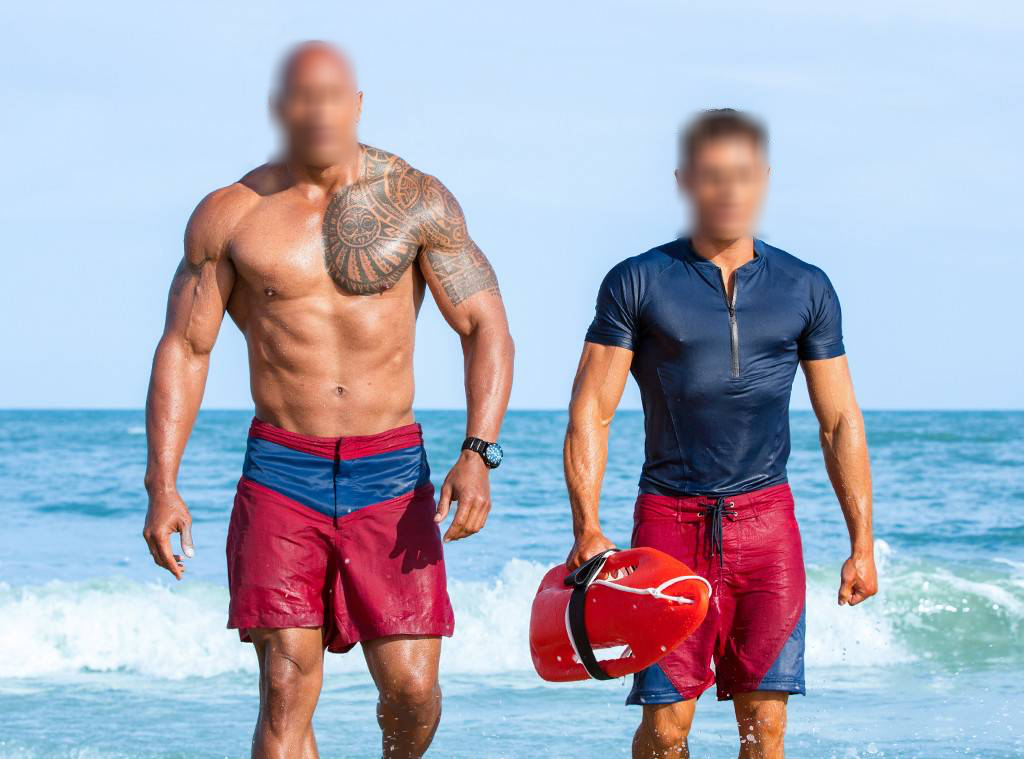

res38: almond.api.helpers.Display = image/png #7752b784-4b6f-4eed-8ef9-ea6d4f15b9f8

In [39]:
Image.fromArray(imgFinal.entriesIterator.toArray, Image.PNG, width=Some("500"))